In [1]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab\ Notebooks/운동

/content/drive/MyDrive/Colab Notebooks/운동


In [4]:
# !pip install catboost

     |████████████████████████████████| 69.2MB 47kB/s 


In [31]:
#라이브러리 설치
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from tqdm import tqdm  #반복문이 어디까지 진행되었는지 표시하는 라이브러리

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [88]:
train = pd.read_csv('train_features.csv')
test = pd.read_csv('test_features.csv')
label = pd.read_csv('train_labels.csv')
sub = pd.read_csv('sample_submission.csv')

In [49]:
test = pd.read_csv('test_features.csv')

In [7]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [8]:
#train_labels.csv 에서 id 가 수행한 동작과 그에 따른 label값을 확인
label

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [12]:
now=time.time()
vel=np.array([(sum(train.iloc[600*i:600*i+j,2]),sum(train.iloc[600*i:600*i+j,3]),sum(train.iloc[600*i:600*i+j,4])) for i in range(0,3125) for j in range(1,601)])*0.02
velocity=pd.DataFrame(vel)
velocity.columns = ['velocity_x', 'velocity_y', 'velocity_z']
velocity=pd.concat([train.iloc[:,0:2],velocity],axis=1)

v_x=velocity['velocity_x']
v_y=velocity['velocity_y']
v_z=velocity['velocity_z']

In [13]:
now=time.time()
vel_test=np.array([(sum(test.iloc[600*i:600*i+j,2]),sum(test.iloc[600*i:600*i+j,3]),sum(test.iloc[600*i:600*i+j,4])) for i in range(0,782) for j in range(1,601)])*0.02
v_test=pd.DataFrame(vel_test)
v_test.columns = ['velocity_x', 'velocity_y', 'velocity_z']
v_test=pd.concat([test.iloc[:,0:2],v_test],axis=1)

v_test_x=v_test['velocity_x']
v_test_y=v_test['velocity_y']
v_test_z=v_test['velocity_z']

In [21]:
v_train = pd.DataFrame(velocity.iloc[:,2:])

In [23]:
v_train

,velocity_x,velocity_y,velocity_z
0,0.024122,-0.003587,-0.002969
1,0.049876,-0.007567,-0.006618
2,0.075968,-0.011469,-0.011685
3,0.101830,-0.016077,-0.015990
4,0.127847,-0.019832,-0.020440
...,...,...,...
1874995,-5.157446,-7.421956,2.693145
1874996,-5.171107,-7.435126,2.699730
1874997,-5.184402,-7.448458,2.707012
1874998,-5.197012,-7.462109,2.714486


In [89]:
train = pd.concat([train ,v_train], axis=1)
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,velocity_x,velocity_y,velocity_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,0.024122,-0.003587,-0.002969
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,0.049876,-0.007567,-0.006618
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,0.075968,-0.011469,-0.011685
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,0.101830,-0.016077,-0.015990
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,0.127847,-0.019832,-0.020440
...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437,-5.157446,-7.421956,2.693145
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087,-5.171107,-7.435126,2.699730
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125,-5.184402,-7.448458,2.707012
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478,-5.197012,-7.462109,2.714486


In [90]:
test = pd.concat([test, v_test.iloc[:,2:]], axis=1)
test

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,velocity_x,velocity_y,velocity_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668,-0.012562,-0.003203,0.003030
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458,-0.021813,-0.002954,0.001955
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043,-0.029083,-0.004790,-0.000645
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771,-0.036118,-0.009587,-0.004506
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912,-0.042376,-0.012062,-0.010878
...,...,...,...,...,...,...,...,...,...,...,...
469195,3906,595,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982,-9.388929,-4.374642,1.648114
469196,3906,596,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291,-9.386863,-4.389821,1.660427
469197,3906,597,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160,-9.384297,-4.404809,1.672151
469198,3906,598,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676,-9.382215,-4.418663,1.683619


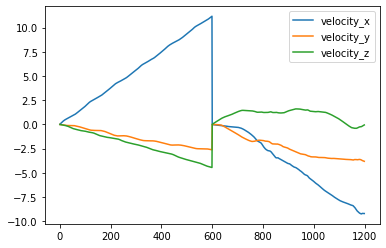

In [41]:
ex=train
ex.iloc[:1200,8:].plot()

In [42]:
from scipy import fftpack
from numpy.fft import *

def fourier_transform_one_signal(t_signal):
    complex_f_signal= fftpack.fft(t_signal)
    amplitude_f_signal=np.abs(complex_f_signal)
    return amplitude_f_signal

In [91]:
fft=[]
for i in tqdm(train['id'].unique()):
    temp=train.loc[train['id']==i]
    for i in train.columns[2:8]:
        temp[i]=fourier_transform_one_signal(temp[i].values)
    fft.append(temp)
train=pd.concat(fft)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [92]:
fft_t=[]
for i in tqdm(test['id'].unique()):
    temp=test.loc[test['id']==i]
    for i in test.columns[2:8]:
        temp[i]=fourier_transform_one_signal(temp[i].values)
    fft_t.append(temp)
test=pd.concat(fft_t)

  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [93]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,velocity_x,velocity_y,velocity_z
0,0,0,558.797337,131.082711,222.252919,1119.161589,2015.703683,709.264425,0.024122,-0.003587,-0.002969
1,0,1,3.233175,15.689279,12.229014,221.599635,361.903330,477.080942,0.049876,-0.007567,-0.006618
2,0,2,4.832535,8.199566,3.901211,357.200415,430.568986,452.096143,0.075968,-0.011469,-0.011685
3,0,3,5.675383,5.330015,2.527445,340.433376,787.558320,467.307109,0.101830,-0.016077,-0.015990
4,0,4,7.415275,7.980024,6.566908,128.188871,1372.095224,715.824074,0.127847,-0.019832,-0.020440
...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,11.743654,3.796333,12.513870,715.873677,1124.494889,645.627066,-5.157446,-7.421956,2.693145
1874996,3124,596,211.498089,82.888508,86.807874,5515.261695,28917.564390,20218.747027,-5.171107,-7.435126,2.699730
1874997,3124,597,12.175349,6.200258,2.084554,343.695161,464.375112,78.097163,-5.184402,-7.448458,2.707012
1874998,3124,598,19.116783,3.830800,6.938661,791.376179,2724.373764,1131.590078,-5.197012,-7.462109,2.714486


In [62]:
# prepare standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

col=train.columns
train_s=train.copy()
test_s=test.copy()

In [94]:
train_s.iloc[:,2:]= scaler.fit_transform(train_s.iloc[:,2:])
train_sc = pd.DataFrame(data = train_s,columns = col)

test_s.iloc[:,2:]= scaler.transform(test_s.iloc[:,2:])
test_sc = pd.DataFrame(data = test_s,columns = col)

In [66]:
x=np.array(train_sc.iloc[:,2:]).reshape(3125, 600, -1)
test_x=np.array(test_sc.iloc[:,2:]).reshape(782, 600, -1)
y = label['label'].values
y = tf.keras.utils.to_categorical(label['label']) 

In [69]:
model = Sequential([Conv1D(filters=128, kernel_size=9, padding='same', input_shape=(600, 9)),
                    BatchNormalization(),
                    Dropout(0.2),
                    Conv1D(filters=256, kernel_size=6, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
                    BatchNormalization(),
                    Conv1D(128, activation= 'relu', kernel_size=3, padding='same'),
                    Dropout(0.2),
                    keras.layers.GlobalAveragePooling1D(),
                    Dense(61, activation='softmax')]) 

In [70]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
model.fit(x,y, epochs=130, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/130
40/40 - 48s - loss: 2.4252 - accuracy: 0.4900 - val_loss: 3.2007 - val_accuracy: 0.2848
Epoch 2/130
40/40 - 1s - loss: 1.8127 - accuracy: 0.5700 - val_loss: 1.8974 - val_accuracy: 0.5760
Epoch 3/130
40/40 - 1s - loss: 1.6261 - accuracy: 0.5872 - val_loss: 1.7041 - val_accuracy: 0.5904
Epoch 4/130
40/40 - 1s - loss: 1.4912 - accuracy: 0.6092 - val_loss: 1.4044 - val_accuracy: 0.6432
Epoch 5/130
40/40 - 1s - loss: 1.3706 - accuracy: 0.6344 - val_loss: 1.2717 - val_accuracy: 0.6528
Epoch 6/130
40/40 - 2s - loss: 1.2729 - accuracy: 0.6572 - val_loss: 1.2570 - val_accuracy: 0.6576
Epoch 7/130
40/40 - 2s - loss: 1.2064 - accuracy: 0.6692 - val_loss: 1.1483 - val_accuracy: 0.6864
Epoch 8/130
40/40 - 2s - loss: 1.1791 - accuracy: 0.6840 - val_loss: 1.1982 - val_accuracy: 0.6752
Epoch 9/130
40/40 - 2s - loss: 1.1012 - accuracy: 0.7048 - val_loss: 1.1100 - val_accuracy: 0.7328
Epoch 10/130
40/40 - 2s - loss: 1.1426 - accuracy: 0.6940 - val_loss: 1.1248 - val_accuracy: 0.7152
Epoch 11

In [72]:
model.evaluate(x,y)

98/98 [==============================] - 1s 8ms/step - loss: 0.4366 - accuracy: 0.8963


[0.43658193945884705, 0.8963199853897095]

In [73]:
pred = model.predict(test_x)
pred

array([[2.1366857e-08, 1.5032410e-18, 1.7436576e-10, ..., 2.6514290e-03,
        3.5530293e-16, 3.2096048e-06],
       [3.4786746e-05, 1.8325007e-10, 1.3437240e-15, ..., 1.8525733e-11,
        4.8376833e-14, 2.8679942e-04],
       [5.2503461e-04, 7.4504219e-02, 3.0725682e-11, ..., 6.1147957e-12,
        8.3140534e-08, 1.9511177e-04],
       ...,
       [3.9098063e-04, 5.9388523e-12, 5.4497557e-12, ..., 8.2761387e-10,
        1.1770107e-12, 4.2588977e-04],
       [2.7049416e-06, 2.3417348e-05, 1.6369444e-08, ..., 4.5780373e-15,
        1.9717086e-09, 3.0010276e-11],
       [9.9979070e-06, 6.4121687e-11, 2.4010707e-15, ..., 6.8586456e-07,
        8.3511128e-13, 4.0711475e-06]], dtype=float32)

In [109]:
cat = CatBoostClassifier(task_type = 'GPU', #GPU 모드
                         loss_function='MultiClass', #다항분류
                         depth=4, 
                         eval_metric='Accuracy', 
                         iterations=800, #반복량
                         l2_leaf_reg=1e-20, 
                         leaf_estimation_iterations=10, 
                         random_seed=42, 
                         verbose = 10)

In [96]:
#지도학습을 진행하기 위해 train, label 병합 (label_desc는 의미가 없어 제거)
train_sc = pd.merge(train_sc, label, on='id')
train_sc.drop('label_desc', axis=1, inplace=True)
train_sc

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,velocity_x,velocity_y,velocity_z,label
0,0,0,27.356382,8.807207,19.465910,0.376992,0.869226,0.150423,0.686057,0.311401,-0.122815,37
1,0,1,-0.054866,0.833464,0.820412,-0.282128,-0.093560,0.011266,0.692467,0.310135,-0.124322,37
2,0,2,0.024046,0.315921,0.081086,-0.182551,-0.053585,-0.003708,0.698962,0.308894,-0.126415,37
3,0,3,0.065632,0.117634,-0.040874,-0.194863,0.154242,0.005408,0.705399,0.307428,-0.128193,37
4,0,4,0.151477,0.300751,0.317742,-0.350724,0.494539,0.154354,0.711875,0.306233,-0.130032,37
...,...,...,...,...,...,...,...,...,...,...,...,...
1874995,3124,595,0.365037,0.011656,0.845701,0.080839,0.350395,0.112282,-0.603682,-2.048499,0.990936,2
1874996,3124,596,10.220817,5.476964,7.441373,3.605246,16.530576,11.843241,-0.607082,-2.052688,0.993656,2
1874997,3124,597,0.386337,0.177768,-0.080193,-0.192468,-0.033904,-0.227861,-0.610391,-2.056930,0.996664,2
1874998,3124,598,0.728823,0.014037,0.350745,0.136284,1.281790,0.403540,-0.613530,-2.061272,0.999752,2


In [103]:
x_train = []

for uid in tqdm(train_sc['id'].unique()):
    temp = np.array(train_sc[train_sc['id'] == uid].iloc[:,2:], np.float32).T #각 id별로 그룹화 후 Transpose 진행
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
x_train = x_train[:,:,:,np.newaxis] #(3125, 7, 600) -> (3125, 7, 600, 1)

x_test = []

for uid in tqdm(test_sc['id'].unique()):
    temp = np.array(test_sc[test_sc['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
x_test = x_test[:,:,:,np.newaxis]

100%|██████████| 782/782 [00:01<00:00, 733.29it/s]


In [104]:
x_train.shape

(3125, 10, 600, 1)

In [99]:
def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)

In [105]:
import random

for _ in range(10):
    aug(x_train, 0, int(random.random()*600))
    print('')

for _ in range(10):
    aug(x_test, 0, int(random.random()*600))
    print('')

x_train = x_train.reshape(-1,10)
x_test = x_test.reshape(-1,10)

x_train = train_sc.iloc[:,2:]
x_test = test_sc.iloc[:,2:]

x_train['id'] = train['id']
x_test['id'] = test['id']

def quantile_75(x):
  return x.quantile(q=0.75)

def quantile_25(x):
  return x.quantile(q=0.25)

features = ['id','acc_x','acc_y','acc_z','gy_x','gy_y','gy_z','velocity_x','velocity_y','velocity_z']
X_train = x_train[features].groupby('id').agg(['max','min','mean','median','std',quantile_75,quantile_25]) #기술 통계량 값 칼럼 생성
X_test = x_test[features].groupby('id').agg(['max','min','mean','median','std',quantile_75,quantile_25])
y_train = label['label']

In [107]:
X_train.reset_index(inplace=True)
X_train.drop(['id'],axis=1,inplace=True)
X_train

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


acc_x                      ... velocity_z                        
            max       min      mean  ...        std quantile_75 quantile_25
0     27.356382 -0.213668 -0.083896  ...   0.522673   -0.568647   -1.422130
1     22.479213 -0.213043  0.073029  ...   0.238628    0.442598    0.164399
2      9.488248 -0.209919  0.032243  ...   0.911377    2.145796    0.627023
3     26.064865 -0.212999 -0.086158  ...   0.431204    0.930821    0.014258
4     19.294977 -0.207729  0.050010  ...   0.276779    0.435930    0.095564
...         ...       ...       ...  ...        ...         ...         ...
3120   8.680147 -0.211938 -0.031737  ...   0.448446    0.875502    0.190986
3121  28.628420 -0.212893 -0.073479  ...   0.085870   -0.266245   -0.365496
3122  32.771410 -0.208057  0.127039  ...   0.356292    0.823536    0.172157
3123   5.165186 -0.213633 -0.031856  ...   0.160195   -0.326821   -0.628494
3124  12.635041 -0.212375 -0.102789  ...   0.325016    0.812994    0.226600

[3125 rows x 63 columns]

In [110]:
cat.fit(X_train, y_train)

0:	learn: 0.5337600	total: 50ms	remaining: 40s
10:	learn: 0.5616000	total: 452ms	remaining: 32.4s
20:	learn: 0.5724800	total: 710ms	remaining: 26.3s
30:	learn: 0.5827200	total: 961ms	remaining: 23.8s
40:	learn: 0.5859200	total: 1.21s	remaining: 22.4s
50:	learn: 0.5980800	total: 1.45s	remaining: 21.4s
60:	learn: 0.6124800	total: 1.72s	remaining: 20.9s
70:	learn: 0.6233600	total: 1.99s	remaining: 20.4s
80:	learn: 0.6294400	total: 2.27s	remaining: 20.2s
90:	learn: 0.6364800	total: 2.54s	remaining: 19.8s
100:	learn: 0.6534400	total: 2.84s	remaining: 19.7s
110:	learn: 0.6630400	total: 3.16s	remaining: 19.6s
120:	learn: 0.6704000	total: 3.43s	remaining: 19.2s
130:	learn: 0.6816000	total: 3.73s	remaining: 19.1s
140:	learn: 0.6889600	total: 4.02s	remaining: 18.8s
150:	learn: 0.6985600	total: 4.31s	remaining: 18.5s
160:	learn: 0.7072000	total: 4.6s	remaining: 18.3s
170:	learn: 0.7190400	total: 4.9s	remaining: 18s
180:	learn: 0.7283200	total: 5.22s	remaining: 17.9s
190:	learn: 0.7344000	total: 5

In [111]:
pred2 = cat.predict_proba(X_test)

# **제출**

In [112]:
sub.iloc[:,1:]=pred
sub

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,2.136686e-08,1.503241e-18,1.743658e-10,1.203777e-07,2.822439e-07,3.313271e-13,9.125311e-07,1.480058e-09,1.022649e-14,1.854946e-02,8.102551e-02,3.293533e-01,2.357901e-04,5.191167e-01,5.860299e-03,1.206039e-07,2.159115e-12,1.393485e-11,8.091426e-11,9.087299e-09,9.539711e-06,1.807953e-06,1.384124e-05,1.275290e-03,1.677637e-02,1.822924e-09,0.000302,2.420094e-14,5.198744e-06,2.326548e-14,4.319986e-05,1.511736e-05,0.000177,5.296097e-13,1.025279e-07,6.791519e-08,1.478693e-02,2.557610e-12,2.807505e-07,2.334629e-05,7.758970e-08,4.465457e-12,7.465028e-07,1.380921e-10,6.273129e-14,1.382072e-06,2.458216e-09,2.001917e-14,1.917223e-05,0.000011,4.812921e-11,6.663376e-03,4.702003e-04,2.605790e-03,7.263665e-07,7.078370e-09,9.196507e-12,1.496616e-09,2.651429e-03,3.553029e-16,3.209605e-06
1,3126,3.478675e-05,1.832501e-10,1.343724e-15,7.409934e-07,7.808322e-10,3.715185e-10,1.145250e-13,6.790769e-11,8.860645e-12,4.540728e-10,1.803327e-09,4.667351e-09,2.790962e-23,7.291105e-10,2.018580e-09,3.573602e-06,1.744741e-08,1.146199e-12,1.260352e-06,1.826489e-13,4.366628e-09,2.654790e-07,1.584253e-07,3.595138e-06,2.955136e-10,1.399245e-06,0.999535,5.793304e-11,1.274927e-09,2.611601e-18,1.550048e-12,1.253932e-15,0.000023,7.964523e-08,3.874847e-07,2.641111e-07,8.461196e-08,6.669044e-11,1.043957e-09,3.513137e-13,3.059266e-07,2.946404e-12,5.142074e-09,5.282201e-12,8.010508e-14,5.643552e-10,3.616094e-12,7.291993e-11,8.324137e-05,0.000025,9.900370e-12,8.525793e-10,2.653327e-17,2.336695e-09,3.350470e-12,1.904117e-11,7.207158e-12,4.329111e-09,1.852573e-11,4.837683e-14,2.867994e-04
2,3127,5.250346e-04,7.450422e-02,3.072568e-11,3.938582e-06,1.503192e-13,9.105812e-11,3.561665e-04,3.130841e-06,3.633281e-06,1.563073e-08,3.308911e-09,5.978000e-09,1.324791e-18,7.287537e-10,3.066519e-08,8.896095e-08,6.307411e-03,1.675824e-07,7.010695e-10,5.039001e-14,6.430575e-11,3.158861e-09,1.050801e-10,1.484167e-09,3.340010e-07,3.116563e-08,0.245685,1.226303e-03,7.808040e-07,4.587847e-09,9.173015e-14,3.399922e-18,0.000181,3.891426e-06,1.638049e-08,1.457136e-04,1.161260e-03,6.768796e-04,1.079345e-06,5.650397e-09,2.214350e-02,3.379071e-11,5.732421e-12,5.415451e-10,9.070706e-08,4.527535e-02,2.638711e-14,3.211074e-02,2.697248e-01,0.297765,1.707699e-13,2.018543e-08,3.013915e-15,1.211033e-16,1.999377e-03,1.490486e-07,1.979593e-07,2.896618e-12,6.114796e-12,8.314053e-08,1.951118e-04
3,3128,3.127904e-05,2.612972e-08,1.251694e-08,1.938718e-07,2.912374e-08,6.667229e-08,4.425059e-10,6.980858e-07,3.384357e-03,2.925206e-12,8.477756e-09,3.331152e-09,1.249362e-14,3.348374e-10,2.032815e-09,6.544135e-05,6.255299e-07,4.837284e-09,7.518329e-09,4.076605e-12,1.404208e-11,1.128117e-06,7.251759e-08,3.123680e-05,2.761736e-06,3.695007e-07,0.989798,1.185763e-08,5.448195e-07,1.352700e-10,3.919806e-08,4.218810e-12,0.001126,4.342696e-06,1.716552e-06,2.645334e-06,8.788845e-07,1.616783e-10,1.113795e-10,3.164492e-14,1.169149e-08,2.194324e-07,2.272774e-06,3.248372e-06,7.248308e-10,1.710286e-11,1.590853e-08,2.307077e-10,1.236036e-04,0.002729,2.348603e-06,2.664371e-08,3.382912e-13,2.540243e-11,3.090474e-10,5.531306e-07,1.414923e-09,7.336685e-04,5.486382e-09,2.612199e-12,1.952561e-03
4,3129,2.667550e-04,1.693623e-12,1.195675e-26,2.392128e-13,3.408390e-05,5.406481e-12,5.690049e-20,4.322319e-16,1.070031e-11,7.350347e-17,1.424934e-12,1.455552e-18,6.003842e-27,2.019649e-16,3.327150e-14,4.056426e-06,2.835260e-10,3.012120e-14,5.524957e-08,3.264861e-16,8.225077e-21,2.208516e-17,8.336129e-08,1.254406e-17,1.946398e-08,1.063903e-08,0.998016,2.628648e-16,3.295703e-10,1.942757e-26,5.378168e-15,1.456011e-21,0.001126,1.413222e-08,2.740813e-11,5.991925e-11,8.228303e-15,1.861765e-18,1.299000e-22,3.198646e-25,4.029958e-12,3.270758e-12,3.946829e-12,1.116113e-10,4.729415e-20,1.582804e-25,3.652178e-12,7.827804e-18,6.576334e-08,0.000019,1.217784e-04,4.681170e-19,

In [113]:
sub.to_csv('submission5.csv', index=False)